<a href="https://colab.research.google.com/github/leticiasdrummond/Modelos-Base/blob/main/1_2_1_caso_referencia_min_custo_energ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pré
Código padrão para funcionar os programas.

In [ ]:
# Instalação limpa (apenas o necessário para CBC)
!pip install -q pyomo
!apt-get install -y -qq coinor-cbc

import pyomo.environ as pyo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



---
# Início do Modelo



In [ ]:
# ============================================================
# 3. DEFINIÇÃO DO HORIZONTE TEMPORAL
# ============================================================

HORIZONTE = 24
T = range(HORIZONTE)  # discretização horária

In [ ]:
# ============================================================
# 4. DADOS DE ENTRADA
# ============================================================

# ---------------------------
# 4.1 Demandas (kW)
# ---------------------------

# Demanda do comércio (kW)
# Os valores correspondentes da imagem do Guilherme representam +/- 17kWmédios
# Ajustado com coeficiente 1,74 para que os valores da imagem referencial do Guilherme tenham 30kWmédios
# - Esta adequação para aumentar da demanda médida fez com que a demanda do comércio fosse quase sempre superior a geração FV, ao contrário da imagem do Guilherme
demanda_comercio = [
    14, 14, 14, 14, 17, 21,            # 00h - 05h (Madrugada baixa)
    28, 35, 49, 56, 56, 49,      # 06h - 11h (Subida manhã)
    47, 45, 42, 40, 40, 35,      # 12h - 17h (Tarde alta)
    30, 21, 14, 12, 14, 14        # 18h - 23h (Descida noite)
]

# Demanda do eletroposto (kW)
# Considera 2 carregadores de 50kW (Max 100kW) com dois picos de uso
# Plotado conferindo a imagem de referencia do Guilherme
demanda_ev = [
    0, 0, 0, 0, 0, 0,            # 00h - 05h
    0, 0, 0, 0, 0, 0,      # 06h - 11h (Pico Manhã ~09h)
    72, 96, 72, 0, 0, 00,     # 12h - 17h (Carga leve tarde -> Início Pico)
    76, 100, 76, 0, 0, 0         # 18h - 23h (Pico Noite ~18h e fim)
]

# ---------------------------
# 4.2 Geração Fotovoltaica (kW)
# ---------------------------

# Geração fotovoltaica (kW)
# Compatível com sistema de 50 kWp (Pico ao meio-dia)
geracao_pv = [
    0, 0, 0, 0, 0, 0,            # 00h - 05h (Sem sol)
    2, 12, 28, 42, 48, 50,       # 06h - 11h (Amanhecer até pico)
    50, 48, 42, 28, 12, 2,       # 12h - 17h (Pico até anoitecer)
    0, 0, 0, 0, 0, 0             # 18h - 23h (Sem sol)
]

# ---------------------------
# 4.3 Parâmetros Econômicos
# ---------------------------

custo_compra = 0.75          # R$/kWh
preco_venda = 0.40           # R$/kWh
custo_degradacao = 0.08      # R$/kWh throughput

# ---------------------------
# 4.4 Parâmetros do BESS
# ---------------------------

capacidade_bess = 50.0       # kWh
potencia_max_bess = 15.0     # kW

soc_min = 0.20 * capacidade_bess
soc_max = 0.95 * capacidade_bess
soc_inicial = 0.50 * capacidade_bess

eta_c = 0.955                # eficiência de carga
eta_d = 0.955                # eficiência de descarga

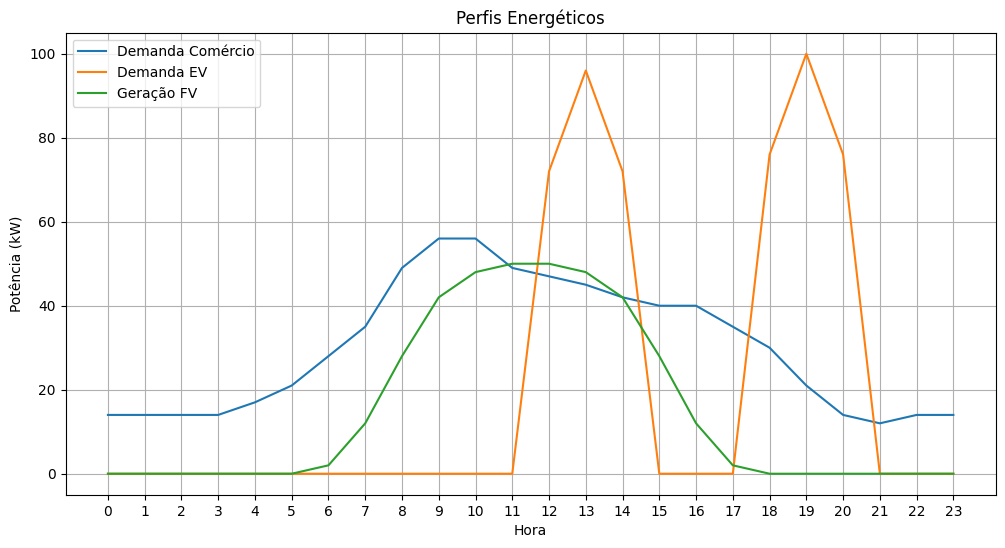

In [ ]:
# ============================================================
# 5. VISUALIZAÇÃO DOS PERFIS
# ============================================================

plt.figure(figsize=(12, 6))
plt.plot(T, demanda_comercio, label="Demanda Comércio")
plt.plot(T, demanda_ev, label="Demanda EV")
plt.plot(T, geracao_pv, label="Geração FV")
plt.xlabel("Hora")
plt.ylabel("Potência (kW)")
plt.title("Perfis Energéticos")
plt.xticks(T)
plt.grid(True)
plt.legend()
plt.show()




---



# Estruturação dos Componentes MILP

In [ ]:
# =========================================================
# 6. CRIAÇÃO DO MODELO DE OTIMIZAÇÃO
# =========================================================

model = pyo.ConcreteModel()
model.T = pyo.Set(initialize=T)

In [ ]:
# ------------------------------------------------------------
# 6.1 Variáveis de decisão
# ------------------------------------------------------------

# -  P_grid : Corresponde a comprar e venda para rede elétrica
model.P_grid = pyo.Var(model.T, domain=pyo.NonNegativeReals)
model.P_export = pyo.Var(model.T, domain=pyo.NonNegativeReals)

# - P_dis/charge : Corresponde ao carregamento da bateria ou pela bateria
model.P_charge = pyo.Var(model.T, domain=pyo.NonNegativeReals)
model.P_discharge = pyo.Var(model.T, domain=pyo.NonNegativeReals)

# - SOC : Estado da bateria
model.SOC = pyo.Var(model.T, domain=pyo.NonNegativeReals)

# - u_charge : Variáveis binárias (bloqueio simultâneo)

model.u_charge = pyo.Var(model.T, domain=pyo.Binary)
model.u_discharge = pyo.Var(model.T, domain=pyo.Binary)

In [ ]:
# ------------------------------------------------------------
# 6.2 Função Objetivo original:
# Minimização do custo total de energia
# ------------------------------------------------------------

def objective_rule(m):
    custo_energia = sum(custo_compra * m.P_grid[t] for t in m.T)
    receita_export = sum(preco_venda * m.P_export[t] for t in m.T)
    custo_deg = sum(custo_degradacao *
                    (m.P_charge[t] + m.P_discharge[t])
                    for t in m.T)
    return custo_energia + custo_deg - receita_export

model.OBJ = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

In [ ]:
# ------------------------------------------------------------
# 6.3 Restrições
# ------------------------------------------------------------

# Balanço de potência horário
def energy_balance_rule(m, t):
    demanda_total = demanda_comercio[t] + demanda_ev[t]
    return (
        m.P_grid[t]
        + geracao_pv[t]
        + m.P_discharge[t]
        ==
        demanda_total
        + m.P_charge[t]
        + m.P_export[t]
    )

model.energy_balance = pyo.Constraint(model.T, rule=energy_balance_rule)

# Dinâmica do SOC
def soc_rule(m, t):
    if t == 0:
        return m.SOC[t] == (
            soc_inicial
            + eta_c * m.P_charge[t]
            - (m.P_discharge[t] / eta_d)
        )
    return m.SOC[t] == (
        m.SOC[t-1]
        + eta_c * m.P_charge[t]
        - (m.P_discharge[t] / eta_d)
    )

model.soc_dyn = pyo.Constraint(model.T, rule=soc_rule)

# Limites operacionais
model.soc_min = pyo.Constraint(model.T,
    rule=lambda m, t: m.SOC[t] >= soc_min)

model.soc_max = pyo.Constraint(model.T,
    rule=lambda m, t: m.SOC[t] <= soc_max)

model.soc_terminal = pyo.Constraint(
    expr=model.SOC[HORIZONTE-1] >= soc_inicial
)

model.charge_limit = pyo.Constraint(
    model.T,
    rule=lambda m, t:
        m.P_charge[t] <= potencia_max_bess * m.u_charge[t]
)

model.discharge_limit = pyo.Constraint(
    model.T,
    rule=lambda m, t:
        m.P_discharge[t] <= potencia_max_bess * m.u_discharge[t]
)

model.no_simultaneous = pyo.Constraint(
    model.T,
    rule=lambda m, t:
        m.u_charge[t] + m.u_discharge[t] <= 1
)



---
# Nova restrição para Potência Máxima contratada da Rede

A saber, o item **8. ORGANIZAÇÃO DOS RESULTADOS** deu erro quando o código para adicionar a restrição adicional era executado.



>

```
 ERROR:pyomo.common.numeric_types:evaluating object as numeric value: P_grid[0]
    (object: <class 'pyomo.core.base.var.VarData'>)
No value for uninitialized VarData object P_grid[0]
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
/tmp/ipython-input-1054406295.py in <cell line: 0>()
      8     "Demanda_EV": demanda_ev,
      9     "PV": geracao_pv,
---> 10     "Grid": [pyo.value(model.P_grid[t]) for t in T],
     11     "Export": [pyo.value(model.P_export[t]) for t in T],
     12     "Carga_BESS": [pyo.value(model.P_charge[t]) for t in T],

/usr/local/lib/python3.12/dist-packages/pyomo/common/numeric_types.py in value(obj, exception)
    382             tmp = obj(exception=True)
    383             if tmp is None:
--> 384                 raise ValueError(
    385                     "No value for uninitialized %s object %s"
    386                     % (type(obj).__name__, obj.name)

ValueError: No value for uninitialized VarData object P_grid[0]
```






In [ ]:
'''
# ============================================================
# RESTRIÇÃO DE DEMANDA MÁXIMA CONTRATADA
# Limite físico da conexão com a rede
# ============================================================

demanda_contratada = 75  # kW

model.limite_demanda = pyo.Constraint(
    model.T,
    rule=lambda m, t: m.P_grid[t] <= demanda_contratada
)
'''

'\n# ============================================================\n# RESTRIÇÃO DE DEMANDA MÁXIMA CONTRATADA\n# Limite físico da conexão com a rede\n# ============================================================\n\ndemanda_contratada = 75  # kW\n\nmodel.limite_demanda = pyo.Constraint(\n    model.T,\n    rule=lambda m, t: m.P_grid[t] <= demanda_contratada\n)\n'



---

# Resoluções Inauteradas

In [ ]:
# ============================================================
# 7. RESOLUÇÃO
# ============================================================

solver = pyo.SolverFactory("cbc")
results = solver.solve(model, tee=False)

In [ ]:
# ============================================================
# 8. ORGANIZAÇÃO DOS RESULTADOS
# ============================================================

df = pd.DataFrame({
    "Hora": list(T),
    "Demanda_Comercio": demanda_comercio,
    "Demanda_EV": demanda_ev,
    "PV": geracao_pv,
    "Grid": [pyo.value(model.P_grid[t]) for t in T],
    "Export": [pyo.value(model.P_export[t]) for t in T],
    "Carga_BESS": [pyo.value(model.P_charge[t]) for t in T],
    "Descarga_BESS": [pyo.value(model.P_discharge[t]) for t in T],
    "SOC": [pyo.value(model.SOC[t]) for t in T],
})

print(df)
print(f"\nCusto Total: R$ {pyo.value(model.OBJ):.2f}")

    Hora  Demanda_Comercio  Demanda_EV  PV        Grid  Export  Carga_BESS  \
0      0                14           0   0   13.087975     0.0         0.0   
1      1                14           0   0   14.000000     0.0         0.0   
2      2                14           0   0   14.000000     0.0         0.0   
3      3                14           0   0   14.000000     0.0         0.0   
4      4                17           0   0   17.000000     0.0         0.0   
5      5                21           0   0   21.000000     0.0         0.0   
6      6                28           0   2   26.000000     0.0         0.0   
7      7                35           0  12   23.000000     0.0         0.0   
8      8                49           0  28   21.000000     0.0         0.0   
9      9                56           0  42   14.000000     0.0         0.0   
10    10                56           0  48    8.000000     0.0         0.0   
11    11                49           0  50    0.000000     0.0  

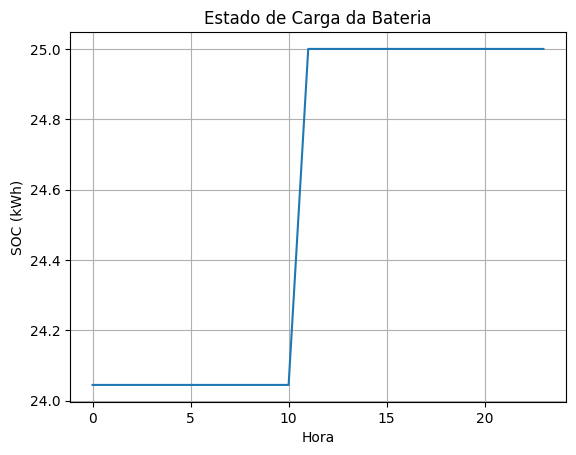

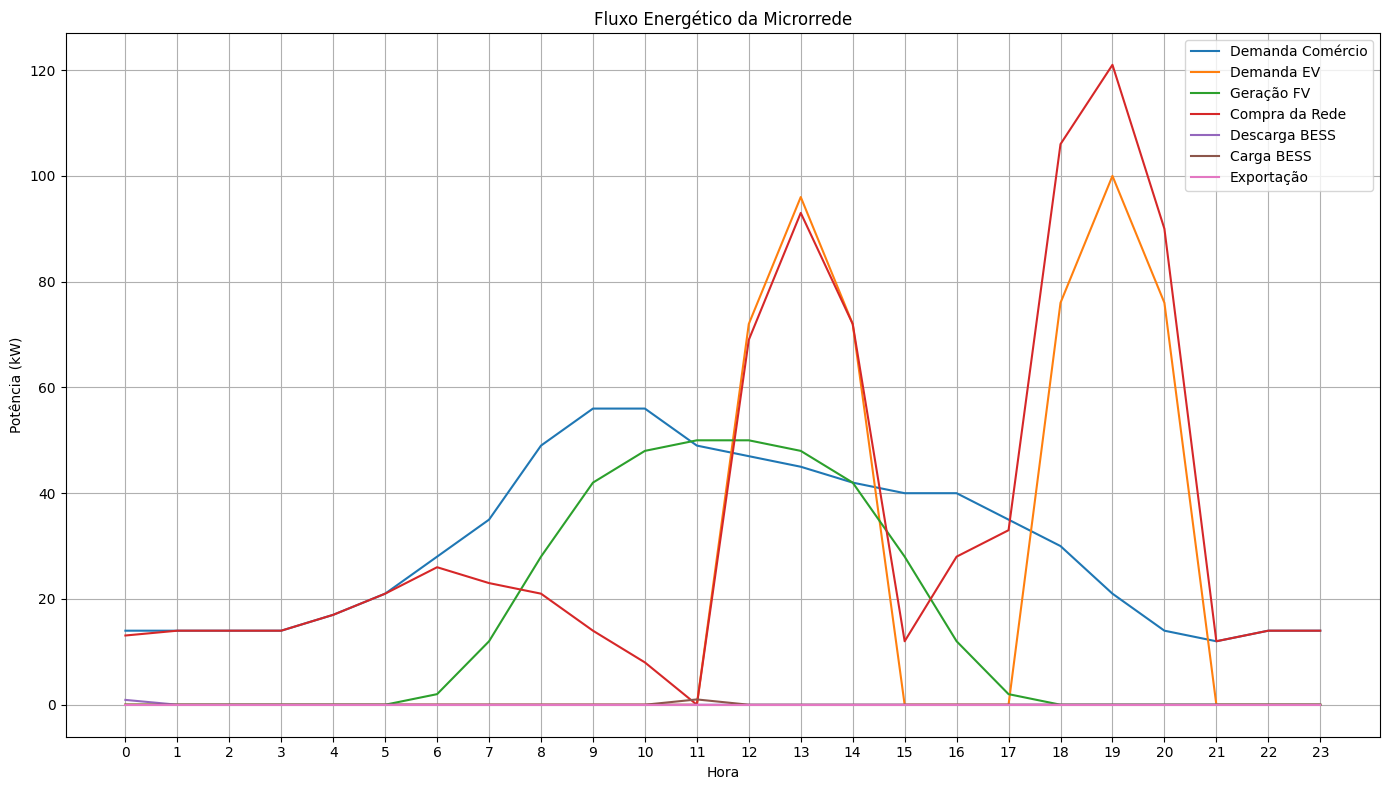

In [ ]:
# ============================================================
# 9. VISUALIZAÇÃO DOS RESULTADOS
# ============================================================

# SOC
plt.figure()
plt.plot(df["Hora"], df["SOC"])
plt.xlabel("Hora")
plt.ylabel("SOC (kWh)")
plt.title("Estado de Carga da Bateria")
plt.grid(True)
plt.show()

# Fluxo energético
plt.figure(figsize=(14, 8))

plt.plot(df["Hora"], df["Demanda_Comercio"], label="Demanda Comércio")
plt.plot(df["Hora"], df["Demanda_EV"], label="Demanda EV")

plt.plot(df["Hora"], df["PV"], label="Geração FV")
plt.plot(df["Hora"], df["Grid"], label="Compra da Rede")
plt.plot(df["Hora"], df["Descarga_BESS"], label="Descarga BESS")
plt.plot(df["Hora"], df["Carga_BESS"], label="Carga BESS")
plt.plot(df["Hora"], df["Export"], label="Exportação")

plt.xlabel("Hora")
plt.ylabel("Potência (kW)")
plt.title("Fluxo Energético da Microrrede")
plt.xticks(df["Hora"])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()